In [1]:
from common import NWSL, Data, Colors, Fonts, Images, add_twitter_handle
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

# Data Collection

Read through stats to get the minutes played in each consecutive stint on a team.

In [2]:
stats = Data.get_nwsl_player_stats(include_early=True)

def get_rows_for_player(player):
    subset = stats[stats["player"] == player].sort_values(["date"], ascending=True)
    return subset.groupby(subset["team"].ne(subset["team"].shift()).cumsum()).agg(
        team=("team", "first"), player=("player", "first"), minutes=("mins_played", "sum")
    )

In [3]:
df = pd.concat([get_rows_for_player(p) for p in stats["player"].unique()]).reset_index(drop=True)
df

,team,player,minutes
0,KC,Leigh Ann Brown,5710.0
1,KC,Nicole Barnhart,9225.0
2,UTA,Nicole Barnhart,2808.0
3,KCC,Nicole Barnhart,460.0
4,WAS,Nicole Barnhart,181.0
...,...,...,...
1301,KCC,Stine Ballisager,225.0
1302,LA,Angelina Anderson,360.0
1303,NJNY,Esther González,340.0
1304,HOU,Andressa,309.0


In [4]:
df_avg = (
    df.groupby("team")
    .agg(avg_minutes=("minutes", "mean"))
    .sort_values("avg_minutes", ascending=False)
    .reset_index()
)
df_avg

,team,avg_minutes
0,CHI,2169.737864
1,POR,1885.830508
2,RGN,1870.016807
3,NC,1865.567568
4,NJNY,1818.552846
5,KC,1773.786885
6,ORL,1701.784946
7,WAS,1689.954198
8,HOU,1548.838462
9,UTA,1485.000000


In [5]:
bins = list(range(0, 6000, 1000))  + [19000]
data = df.groupby(['team', pd.cut(df["minutes"], bins)]).size().unstack()
data

minutes,"(0, 1000]","(1000, 2000]","(2000, 3000]","(3000, 4000]","(4000, 5000]","(5000, 19000]"
team,,,,,,
BOS,45,20,5,7,3,1
CHI,48,20,11,6,6,12
HOU,68,28,19,4,2,9
KC,30,11,9,2,3,6
KCC,29,13,4,5,2,0
LA,17,9,4,4,0,0
LOU,21,17,5,3,1,1
NC,41,12,5,4,1,11
NJNY,51,36,9,12,4,11


In [6]:
labels = []
for previous, current in zip(bins, bins[1:]):
    previous_fmt = (str(int(previous / 1000)) + "k").replace("0k", "0")
    current_fmt = (str(int(current / 1000)) + "k").replace("0k", "0")
    if current == bins[-1]:
        labels.append(previous_fmt + "+")
    else:
        labels.append(previous_fmt + "-" + current_fmt)
labels

['0-1k', '1k-2k', '2k-3k', '3k-4k', '4k-5k', '5k+']

# Visualization

<Figure size 1152x720 with 0 Axes>

<Figure size 6400x4000 with 0 Axes>

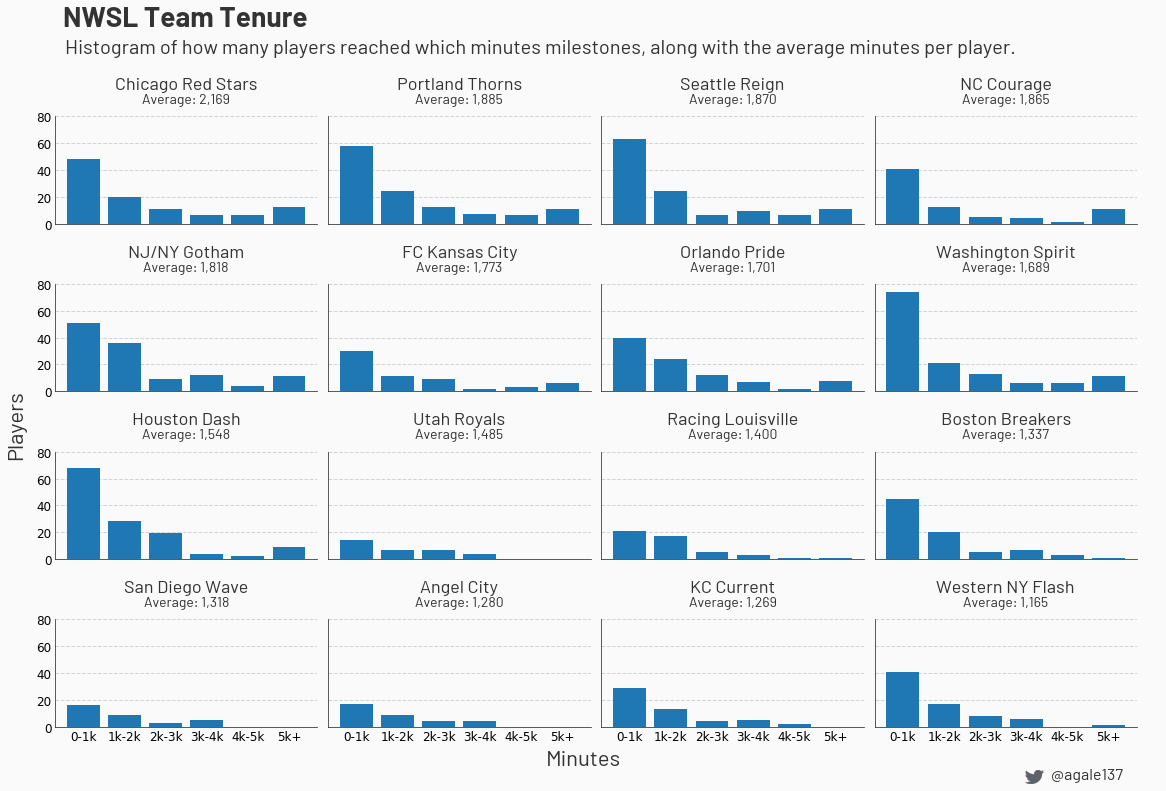

In [12]:
# General
plt.clf()
plt.rcParams["figure.figsize"] = (16, 10)
plt.figure(dpi=400, facecolor=Colors.WHITE)
ROWS = 4
COLS = 4
fig, axs = plt.subplots(ROWS, COLS)
fig.patch.set_facecolor(Colors.WHITE)

for i, row in df_avg.iterrows():
    team = row["team"]
    values = data.loc[team]

    ax = axs[int(i / COLS), i % COLS]
    ax.set_facecolor(Colors.WHITE)

    # Plot data
    ax.bar(list(range(0, len(bins) - 1)), values)

    # Title
    ax.set_title(
        NWSL.name(team), fontproperties=Fonts.BARLOW, size=18, color=Colors.BLACK, y=1.2
    )
    avg_mins = int(row["avg_minutes"])
    ax.text(
        2.5,
        90,
        "Average: " + f"{avg_mins:,}",
        ha="center",
        fontproperties=Fonts.BARLOW,
        size=14,
        color=Colors.BLACK,
    )

    # Axes & ticks
    ax.spines[["right", "top"]].set_visible(False)
    ax.spines[["bottom", "left"]].set_color(Colors.BLACK)
    ax.set_axisbelow(True)
    ax.grid(axis="y", which="both", ls="--", color=Colors.LIGHT_GRAY, linewidth=1)
    ax.tick_params(axis="both", which="both", length=0, labelsize=12)
    if i % COLS != 0:
        ax.yaxis.set_ticklabels([])
        ax.yaxis.set_ticks_position("none")

    if int(i / COLS) != ROWS - 1:
        ax.xaxis.set_ticklabels([])
        ax.xaxis.set_ticks_position("none")
    else:
        ax.set_xticks(list(range(0, len(bins) - 1)))
        ax.set_xticklabels(labels)

    ax.set_ylim([0, 80])
    ax.set_yticks([0, 20, 40, 60, 80])

# Axis labels
fig.supxlabel(
    "Minutes", x=0.51, y=0.02, fontproperties=Fonts.BARLOW, size=22, color=Colors.BLACK
)
fig.supylabel(
    "Players",
    x=0.01,
    fontproperties=Fonts.BARLOW,
    size=22,
    color=Colors.BLACK,
)


# Proper spacing between subplots
fig.tight_layout()


# Titles
plt.suptitle(
    "NWSL Team Tenure",
    x=0.165,
    y=1.08,
    fontproperties=Fonts.BARLOW_BOLD,
    fontsize=28,
    color=Colors.BLACK,
)
plt.figtext(
    0.06,
    1.015,
    "Histogram of how many players reached which minutes milestones, along with the average minutes per player.",
    fontproperties=Fonts.BARLOW,
    fontsize=20,
    color=Colors.BLACK,
)

add_twitter_handle(fig, x=0.89, y=0.0, fs=16, w=0.02)

# Save image
plt.savefig(
    "images/minutes_team.png",
    bbox_inches="tight",
    pad_inches=0.5,
    dpi=400,
)